In [1]:
import Pkg
Pkg.activate("..")

  Activating project at `~/research/xaqlab/ergm.jl`


# Hessian Standard Error via Bootstrap

In [ ]:
using ergm.spaces
using ergm.models
using ergm.sampler
using ergm.stats
using LinearAlgebra
using Statistics

n = 30
stats = DeltaStats(
    function(G)
        [
            sum(G.adjacency) / (n * (n - 1)),
            tr(G.adjacency ^ 3) / (n * (n - 1) * (n - 2))
        ]
    end,
    function(G, s, u)
        i, x = u
        s + [
            (x - G[i]) / (n * (n - 1)),
            3 * (x - G[i]) * dot(G.adjacency[i[2], :], G.adjacency[:, i[1]]) / (n * (n - 1) * (n - 2))
        ]
    end
)
θ0 = [-20.0, 200.0]
G0 = DiGraph(rand(Bool, (n, n)))
m = ExponentialFamily(stats, θ0)
s = ParallelGibbsSampler(
    G0,
    m,
    10,
    3,
    Threads.nthreads()
)
Gs, ss = sample(s, 20000)

In [29]:
import StatsBase

m = length(Gs)
n_bootstrap = 1000
n_estim = 200
Hs = []
λs = []

for _ ∈ 1:n_bootstrap
    is = StatsBase.sample(1:m, n_estim; replace=true)
    X = ss[:, is]
    H = 1 / (n_estim - 1) * X * X'
    G = H^-1
    push!(λs, [G[1, 1], G[2, 2]])
end

In [71]:
std(ss, dims=2) / sqrt(size(ss, 2))

2×1 Matrix{Float64}:
 0.00018673369111702406
 0.0001694086972149202

In [72]:
mean(ss, dims=2)

2×1 Matrix{Float64}:
 0.5455502298850511
 0.16405418719211495

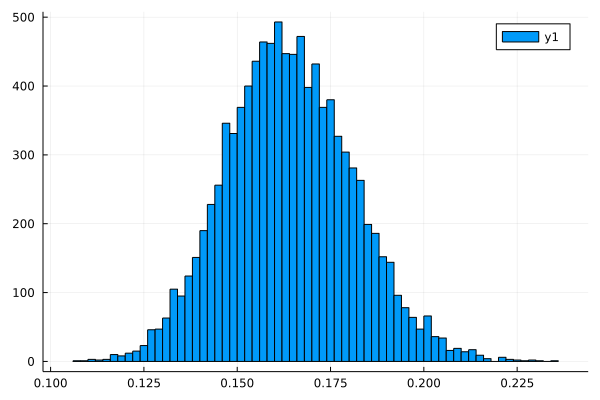

In [70]:
using Plots

gr()
histogram(ss[2, :])

# Visualizing Loss Surface for Directed Edge-Triangle

In [2]:
using ergm.spaces
using ergm.models
using ergm.sampler
using ergm.stats
using LinearAlgebra
using Statistics

n = 30
stats = DeltaStats(
    function(G)
        [
            sum(G.adjacency) / (n * (n - 1)),
            tr(G.adjacency ^ 3) / (n * (n - 1) * (n - 2))
        ]
    end,
    function(G, s, u)
        i, x = u
        s + [
            (x - G[i]) / (n * (n - 1)),
            3 * (x - G[i]) * dot(G.adjacency[i[2], :], G.adjacency[:, i[1]]) / (n * (n - 1) * (n - 2))
        ]
    end
)
G0 = DiGraph(rand(Bool, (n, n)))
m = ExponentialFamily(stats, zeros(2))
s = ParallelGibbsSampler(
    G0,
    m,
    10,
    3,
    Threads.nthreads()
)
θs = Iterators.product(-1e5:2e4:1e5, -1e7:2e6:1e7)

Base.Iterators.ProductIterator{Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}((-100000.0:20000.0:100000.0, -1.0e7:2.0e6:1.0e7))

In [6]:
using DataFrames
using ProgressMeter

df = DataFrame(θ1 = Float64[], θ2 = Float64[], E1 = Float64[], E2 = Float64[])

@showprogress 1 for (i, θ) ∈ enumerate(θs)
    update_params(m, θ)
    _, ss = sample(s, 5000)
    ms = mean(ss, dims=2)
    push!(df, (θ[1], θ[2], ms[1], ms[2]))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:20:50


In [12]:
using Plots
using JLD
using DataFrames

df = load("surf.jld", "df2")
Et = [0.01, 1.2e-5]
L(E1, E2) = (E1 .- Et[1]) .^ 2 + (E2 .- Et[2]) .^ 2
df = transform(df, [:E1, :E2] => L => :L)
gr()
surface(df.θ1, df.θ2, df.L)

Error encountered while load FileIO.File{FileIO.DataFormat{:JLD}, String}("surf.jld").

Fatal error:


LoadError: HDF5.API.H5Error: Error opening object //df2
libhdf5 Stacktrace:
 [1] [0m[1mH5G__loc_find_cb[22m: Symbol table/Object not found
[90m     object 'df2' doesn't exist[39m
  ⋮
 [9] [0m[1mH5Oopen[22m: Object header/Can't open object
[90m     unable to open object[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90m~/.julia/packages/HDF5/auFb7/src/api/[39m[90m[4merror.jl:18[24m[39m[90m [inlined][39m
  [2] [0m[1mh5o_open[22m[0m[1m([22m[90mloc_id[39m::[0mInt64, [90mpathname[39m::[0mString, [90mlapl_id[39m::[0mInt64[0m[1m)[22m
[90m    @ [39m[35mHDF5.API[39m [90m~/.julia/packages/HDF5/auFb7/src/api/[39m[90m[4mfunctions.jl:1128[24m[39m
  [3] [0m[1mgetindex[22m
[90m    @ [39m[90m~/.julia/packages/JLD/XHcYy/src/[39m[90m[4mJLD.jl:297[24m[39m[90m [inlined][39m
  [4] [0m[1mread[22m[0m[1m([22m[90mparent[39m::[0mJLD.JldFile, [90mname[39m::[0mString[0m[1m)[22m
[90m    @ [39m[36mJLD[39m [90m~/.julia/packages/JLD/XHcYy/src/[39m[90m[4mJLD.jl:360[24m[39m
  [5] [0m[1m#48[22m
[90m    @ [39m[90m~/.julia/packages/JLD/XHcYy/src/[39m[90m[4mJLD.jl:1279[24m[39m[90m [inlined][39m
  [6] [0m[1mjldopen[22m[0m[1m([22m::[0mJLD.var"#48#49"[90m{String}[39m, ::[0mString, ::[0mVararg[90m{String}[39m; [90mkws[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[36mJLD[39m [90m~/.julia/packages/JLD/XHcYy/src/[39m[90m[4mJLD.jl:262[24m[39m
  [7] [0m[1mjldopen[22m
[90m    @ [39m[90m~/.julia/packages/JLD/XHcYy/src/[39m[90m[4mJLD.jl:260[24m[39m[90m [inlined][39m
  [8] [0m[1mfileio_load[22m[0m[1m([22m[90mf[39m::[0mFileIO.File[90m{FileIO.DataFormat{:JLD}, String}[39m, [90mvarname[39m::[0mString[0m[1m)[22m
[90m    @ [39m[36mJLD[39m [90m~/.julia/packages/JLD/XHcYy/src/[39m[90m[4mJLD.jl:1278[24m[39m
  [9] [0m[1m#invokelatest#2[22m
[90m    @ [39m[90m./[39m[90m[4messentials.jl:716[24m[39m[90m [inlined][39m
 [10] [0m[1minvokelatest[22m
[90m    @ [39m[90m./[39m[90m[4messentials.jl:714[24m[39m[90m [inlined][39m
 [11] [0m[1maction[22m[0m[1m([22m[90mcall[39m::[0mSymbol, [90mlibraries[39m::[0mVector[90m{Union{Base.PkgId, Module}}[39m, [90mfile[39m::[0mFileIO.Formatted, [90margs[39m::[0mString; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[32mFileIO[39m [90m~/.julia/packages/FileIO/u9YLx/src/[39m[90m[4mloadsave.jl:219[24m[39m
 [12] [0m[1maction[22m
[90m    @ [39m[90m~/.julia/packages/FileIO/u9YLx/src/[39m[90m[4mloadsave.jl:197[24m[39m[90m [inlined][39m
 [13] [0m[1maction[22m[0m[1m([22m[90mcall[39m::[0mSymbol, [90mlibraries[39m::[0mVector[90m{Union{Base.PkgId, Module}}[39m, [90msym[39m::[0mSymbol, [90mfile[39m::[0mString, [90margs[39m::[0mString; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[32mFileIO[39m [90m~/.julia/packages/FileIO/u9YLx/src/[39m[90m[4mloadsave.jl:185[24m[39m
 [14] [0m[1maction[22m
[90m    @ [39m[90m~/.julia/packages/FileIO/u9YLx/src/[39m[90m[4mloadsave.jl:185[24m[39m[90m [inlined][39m
 [15] [0m[1mload[22m[0m[1m([22m[90mfile[39m::[0mString, [90margs[39m::[0mString; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[32mFileIO[39m [90m~/.julia/packages/FileIO/u9YLx/src/[39m[90m[4mloadsave.jl:113[24m[39m
 [16] [0m[1mload[22m[0m[1m([22m[90mfile[39m::[0mString, [90margs[39m::[0mString[0m[1m)[22m
[90m    @ [39m[32mFileIO[39m [90m~/.julia/packages/FileIO/u9YLx/src/[39m[90m[4mloadsave.jl:110[24m[39m
 [17] top-level scope
[90m    @ [39m[90m[4mIn[12]:5[24m[39m

Try fitting single subsample

In [58]:
using ergm.spaces
using ergm.models
using ergm.sampler
using ergm.stats
using LinearAlgebra
using Statistics

n = 30
stats = DeltaStats(
    function(G)
        p = sum(G.adjacency) / (n * (n - 1))
        [
            sum(G.adjacency) / (n * (n - 1)),
            tr(G.adjacency ^ 3) / (n * (n - 1) * (n - 2)) - p ^ 3
        ]
    end,
    function(G, s, u)
        i, x = u
        p = s[1]
        dp = (x - G[i]) / (n * (n - 1))
        s + [
            (x - G[i]) / (n * (n - 1)),
            3 * (x - G[i]) * dot(G.adjacency[i[2], :], G.adjacency[:, i[1]]) / (n * (n - 1) * (n - 2)) - (p + dp) ^ 3 + p ^ 3
        ]
    end
)
G0 = Graph(rand(Bool, (n, n)))
m = ExponentialFamily(stats, zeros(2))
s = ParallelGibbsSampler(
    G0,
    m,
    10,
    3,
    Threads.nthreads()
)
θs = [[θ1, θ2] for θ1 ∈ map(p -> sign(p) * 10 ^ abs(p), -5:0.3:5) for θ2 ∈ map(p -> sign(p) * 10 ^ abs(p), -5:0.3:5)];

In [59]:
using DataFrames

df2 = DataFrame(θ1 = Float64[], θ2 = Float64[], E1 = Float64[], E2 = Float64[])

for (i, θ) ∈ enumerate(θs)
    if i % 20 == 0
        println("$i/$(length(θs))")
        flush(stdout)
    end
        
    update_params(m, θ)
    s = ParallelGibbsSampler(
        G0,
        m,
        10,
        3,
        Threads.nthreads()
    )
    _, ss = sample(s, 100)
    ms = mean(ss, dims=2)
    push!(df2, (θ[1], θ[2], ms[1], ms[2]))
end

20/1156
40/1156
60/1156
80/1156
100/1156
120/1156
140/1156
160/1156
180/1156
200/1156
220/1156
240/1156
260/1156
280/1156
300/1156
320/1156
340/1156
360/1156
380/1156
400/1156
420/1156
440/1156
460/1156
480/1156
500/1156
520/1156
540/1156
560/1156
580/1156
600/1156
620/1156
640/1156
660/1156
680/1156
700/1156
720/1156
740/1156
760/1156
780/1156
800/1156
820/1156
840/1156
860/1156
880/1156
900/1156
920/1156
940/1156
960/1156
980/1156
1000/1156
1020/1156
1040/1156
1060/1156
1080/1156
1100/1156
1120/1156
1140/1156


In [49]:
using JLD

save("surf.jld", "df2", df2)

In [47]:
using JLD
using DataFrames

df2 = load("surf.jld")["df2"];

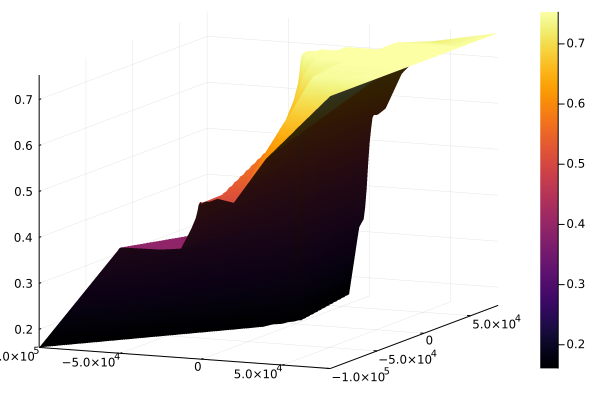

In [65]:
using PyPlot
using Plots

Et = [0.01, 1.2e-5]
L(E1, E2) = (E1 .- Et[1]) .^ 2 + (E2 .- Et[2]) .^ 2
df2 = transform(df2, [:E1, :E2] => L => :L)
gr()
plot(df2.θ1, df2.θ2, df2.L, st=:surface)